In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import re
import os
import json
from tweepy import OAuthHandler
from timeit import default_timer as timer
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Gathering

### Twitter Archive

In [2]:
# Read the csv format file
twitter_archive = pd.read_csv('twitter-archive-enhanced-2.csv')

In [3]:
twitter_archive.sort_values('timestamp')
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [4]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

### Image Predictions

In [5]:
#Download from the URL programatically 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read the TSV format file
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t' )

### Twitter API and Json files

In [6]:
'''
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'Ko4SHPyc6j6oP7jqgftKBjklT'
consumer_secret = '5H8WDpu3V1bw1kcvXGI52FJ62BjHOi5Q8VTkshtQKtsB1eUi07'
access_token = '872471705494495232-YarWBuAqzugztqf4IhP08gl0CAEE4br'
access_secret = 'Sw4DUud3pWFfKpYJzi8N348yToLYqzqu0l8tlojyGLaPN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
'''

"\n# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\nconsumer_key = 'Ko4SHPyc6j6oP7jqgftKBjklT'\nconsumer_secret = '5H8WDpu3V1bw1kcvXGI52FJ62BjHOi5Q8VTkshtQKtsB1eUi07'\naccess_token = '872471705494495232-YarWBuAqzugztqf4IhP08gl0CAEE4br'\naccess_secret = 'Sw4DUud3pWFfKpYJzi8N348yToLYqzqu0l8tlojyGLaPN'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)\n"

In [7]:
'''
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    
    # This loop will take 20-30 minutes to run due to Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = twitter_archive_df.tweet_id.values\nlen(tweet_ids)\n\n# Query Twitter\'s API for JSON data for each tweet ID in the Twitter archive\ncount = 0\nfails_dict = {}\nstart = timer()\n\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith open(\'tweet_json.txt\', \'w\') as outfile:\n    \n    # This loop will take 20-30 minutes to run due to Twitter\'s rate limit\n    for tweet_id in tweet_ids:\n        count += 1\n        print(str(count) + ": " + str(tweet_id))\n        try:\n            tweet = api.get_status(tweet_id, tweet_mode=\'extended\')\n            print("Success")\n            json.dump(tweet._json, outfile)\n            outfile.write(\'\n\')\n        except tweepy.TweepError as e:\n            print("Fail")\n            fails_dict[tweet_id] = e\n            pass\nend = timer()\nprint(end - start)\nprint(fails_dict)\n'

In [8]:
# Read the data from tweet_json.txt file
tweets_full_df = pd.read_json('tweet-json.txt', lines=True)
tweets_full_df.head()

created_at                  id              id_str  \
0 2017-08-01 16:23:56+00:00  892420643555336193  892420643555336192   
1 2017-08-01 00:17:27+00:00  892177421306343426  892177421306343424   
2 2017-07-31 00:18:03+00:00  891815181378084864  891815181378084864   
3 2017-07-30 15:58:51+00:00  891689557279858688  891689557279858688   
4 2017-07-29 16:00:24+00:00  891327558926688256  891327558926688256   

                                           full_text  truncated  \
0  This is Phineas. He's a mystical boy. Only eve...      False   
1  This is Tilly. She's just checking pup on you....      False   
2  This is Archie. He is a rare Norwegian Pouncin...      False   
3  This is Darla. She commenced a snooze mid meal...      False   
4  This is Franklin. He would like you to stop ca...      False   

  display_text_range                                           entities  \
0            [0, 85]  {'hashtags': [], 'symbols': [], 'user_mentions...   
1           [0, 138]  {'hashtags': [], 'symbols': [], 'user_mentions...   
2           [0, 121]  {'hashtags': [], 'symbols': [], 'user_mentions...   
3            [0, 79]  {'hashtags': [], 'symbols': [], 'user_mentions...   
4           [0, 138]  {'hashtags': [{'text': 'BarkWeek', 'indices': ...   

                                   extended_entities  \
0  {'media': [{'id': 892420639486877696, 'id_str'...   
1  {'media': [{'id': 892177413194625024, 'id_str'...   
2  {'media': [{'id': 891815175371796480, 'id_str'...   
3  {'media': [{'id': 891689552724799489, 'id_str'...   
4  {'media': [{'id': 891327551943041024, 'id_str'...   

                                              source  in_reply_to_status_id  \
0  <a href="http://twitter.com/download/iphone" r...                    NaN   
1  <a href="http://twitter.com/download/iphone" r...                    NaN   
2  <a href="http://twitter.com/download/iphone" r...                    NaN   
3  <a href="http://twitter.com/download/iphone" r...                    NaN   
4  <a href="http://twitter.com/download/iphone" r...                    NaN   

   ...  favorite_count  favorited  retweeted possibly_sensitive  \
0  ...           39467      False      False                0.0   
1  ...           33819      False      False                0.0   
2  ...           25461      False      False                0.0   
3  ...           42908      False      False                0.0   
4  ...           41048      False      False                0.0   

  possibly_sensitive_appealable  lang  retweeted_status quoted_status_id  \
0                           0.0    en               NaN              NaN   
1                           0.0    en               NaN              NaN   
2                           0.0    en               NaN              NaN   
3                           0.0    en               NaN              NaN   
4                           0.0    en               NaN              NaN   

   quoted_status_id_str  quoted_status  
0                   NaN            NaN  
1                   NaN            NaN  
2                   NaN            NaN  
3                   NaN            NaN  
4                   NaN            NaN  

[5 rows x 31 columns]

In [9]:
#  Select all the data that will be analyzed and create tweets_df
tweets_df = tweets_full_df[['id', 'favorite_count','retweet_count']]
tweets_df = tweets_df.rename(columns={'id':'tweet_id'})
tweets_df.head()

tweet_id  favorite_count  retweet_count
0  892420643555336193           39467           8853
1  892177421306343426           33819           6514
2  891815181378084864           25461           4328
3  891689557279858688           42908           8964
4  891327558926688256           41048           9774

# Data Assesment

### Twitter Archive

In [18]:
twitter_archive

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
19    888202515573088257                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
22    887517139158093824                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
24    887343217045368832                    NaN                  NaN   
25    887101392804085760                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
28    886680336477933568                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
...                  ...                    ...                  ...   
2326  666411507551481857                    NaN                  NaN   
2327  666407126856765440                    NaN                  NaN   
2328  666396247373291520                    NaN                  NaN   
2329  666373753744588802                    NaN                  NaN   
2330  666362758909284353                    NaN                  NaN   
2331  666353288456101888                    NaN                  NaN   
2332  666345417576210432                    NaN                  NaN   
2333  666337882303524864                    NaN                  NaN   
2334  666293911632134144                    NaN                  NaN   
2335  666287406224695296                    NaN                  NaN   
2336  666273097616637952                    NaN                  NaN   
2337  666268910803644416                    NaN                  NaN   
2338  666104133288665088                    NaN                  NaN   
2339  666102155909144576                    NaN                  NaN   
2340  666099513787052032                    NaN                  NaN   
2341  666094000022159362                    NaN                  NaN   
2342  666082916733198337                    NaN                  NaN   
2343  666073100786774016                    NaN                  NaN   
2344  666071193221509120                    NaN                  NaN   
2345  666063827256086533                    NaN                  NaN   
2346  666058600524156928                    NaN                  NaN   
2347  666057090499244032                    NaN                  NaN   
2348  666055525042405380                    NaN                  NaN   
2349  666051853826850816                    NaN         

In [10]:
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [11]:
twitter_archive.tail()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
2351  2015-11-16 00:24:50 +0000   
2352  2015-11-16 00:04:52 +0000   
2353  2015-11-15 23:21:54 +0000   
2354  2015-11-15 23:05:30 +0000   
2355  2015-11-15 22:32:08 +0000   

                                                 source  \
2351  <a href="http://twitter.com/download/iphone" r...   
2352  <a href="http://twitter.com/download/iphone" r...   
2353  <a href="http://twitter.com/download/iphone" r...   
2354  <a href="http://twitter.com/download/iphone" r...   
2355  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
2351  Here we have a 1949 1st generation vulpix. Enj...                  NaN   
2352  This is a purebred Piers Morgan. Loves to Netf...                  NaN   
2353  Here is a very happy pup. Big fan of well-main...                  NaN   
2354  This is a western brown Mitsubishi terrier. Up...                  NaN   
2355  Here we have a Japanese Irish Setter. Lost eye...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
2351                       NaN                        NaN   
2352                       NaN                        NaN   
2353                       NaN                        NaN   
2354                       NaN                        NaN   
2355                       NaN                        NaN   

                                          expanded_urls  rating_numerator  \
2351  https://twitter.com/dog_rates/status/666049248...                 5   
2352  https://twitter.com/dog_rates/status/666044226...                 6   
2353  https://twitter.com/dog_rates/status/666033412...                 9   
2354  https://twitter.com/dog_rates/status/666029285...                 7   
2355  https://twitter.com/dog_rates/status/666020888...                 8   

      rating_denominator  name doggo floofer pupper puppo  
2351                  10  None  None    None   None  None  
2352                  10     a  None    None   None  None  
2353                  10     a  None    None   None  None  
2354                  10     a  None    None   None  None  
2355                  10  None  None    None   None  None

##### Assesment of twitter_archive programmatically

In [12]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
twitter_archive.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [14]:
# Check twitter_archive for duplicity
sum(twitter_archive.duplicated())

0

In [15]:
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [16]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
# Check if any tweets of them are retweets
len(twitter_archive[twitter_archive.retweeted_status_id.isnull() == False])

181

In [18]:
# Sorting tweets by rating_denominator values
twitter_archive.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [19]:
# Sorting tweets by rating numerator values
twitter_archive.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

### Image Predictions

#### Assesment of image predictions visually

In [40]:
image_predictions

tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    666071193221509120    https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg   
12    666073100786774016    https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg   
13    666082916733198337    https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg   
14    666094000022159362    https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg   
15    666099513787052032    https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg   
16    666102155909144576    https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg   
17    666104133288665088    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18    666268910803644416    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
19    666273097616637952    https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg   
20    666287406224695296    https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg   
21    666293911632134144    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
22    666337882303524864    https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg   
23    666345417576210432    https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg   
24    666353288456101888    https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg   
25    666362758909284353    https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
26    666373753744588802    https://pbs.twimg.com/media/CT9vZEYWUAAlZ05.jpg   
27    666396247373291520    https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg   
28    666407126856765440    https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg   
29    666411507551481857    https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg   
...                  ...                                                ...   
2045  886366144734445568    https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg   
2046  886680336477933568    https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
2047  886736880519319552    https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg   
2048  886983233522544640    https://pbs.twimg.com/media/DE8yicJW0AAAvBJ.jpg   
2049  887101392804085760    https://pbs.twimg.com/media/DE-eAq6UwAA-jaE.jpg   
2050  887343217045368832  https://pbs.twimg.com/ext_tw_video_thumb/88734...   
2051  887473957103951883    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2052  887517139158093824  https://pbs.twimg.com/ext_tw_video_thumb/88751...   
2053  887705289381826560    https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg   
2054  888078434458587136    https://pbs.twimg.com/media/DFMWn56WsAAkA7B.jpg   
2055  888202515573088257    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2056  888554962724278272    https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg   
2057  888804989199671297    https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg   
2058  888917238123831296    https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg   
2059  889278841981685760  https://pbs.twimg.com/ext_tw_video_thumb/88927...   
2060  889531135344209921    https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg   
2061  889638837579907072    https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg   
2062  889665388333682689    https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg   
2063  889880896479866881    https://pbs.twimg.com/media/DFl99B1WsA

In [20]:
image_predictions.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [21]:
image_predictions.tail()

tweet_id                                          jpg_url  \
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num           p1   p1_conf  p1_dog                  p2   p2_conf  \
2070        2       basset  0.555712    True    English_springer  0.225770   
2071        1  paper_towel  0.170278   False  Labrador_retriever  0.168086   
2072        1    Chihuahua  0.716012    True            malamute  0.078253   
2073        1    Chihuahua  0.323581    True            Pekinese  0.090647   
2074        1       orange  0.097049   False               bagel  0.085851   

      p2_dog                           p3   p3_conf  p3_dog  
2070    True  German_short-haired_pointer  0.175219    True  
2071    True                      spatula  0.040836   False  
2072    True                       kelpie  0.031379    True  
2073    True                     papillon  0.068957    True  
2074   False                       banana  0.076110   False

#### Assessment of image pedictions programmatically

In [22]:
image_predictions.shape

(2075, 12)

In [23]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
# Check the file for duplicity
sum(image_predictions.duplicated())

0

In [25]:
image_predictions.img_num.unique()

array([1, 4, 2, 3], dtype=int64)

In [26]:
sum(image_predictions.jpg_url.duplicated()==True)

66

In [27]:
image_predictions['img_num'].value_counts()


1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [28]:
image_predictions.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

### Tweet Json File

#### Assessment of Tweet Json File Visually

In [29]:
tweets_df

tweet_id  favorite_count  retweet_count
0     892420643555336193           39467           8853
1     892177421306343426           33819           6514
2     891815181378084864           25461           4328
3     891689557279858688           42908           8964
4     891327558926688256           41048           9774
...                  ...             ...            ...
2349  666049248165822465             111             41
2350  666044226329800704             311            147
2351  666033412701032449             128             47
2352  666029285002620928             132             48
2353  666020888022790149            2535            532

[2354 rows x 3 columns]

In [30]:
tweets_df.head()

tweet_id  favorite_count  retweet_count
0  892420643555336193           39467           8853
1  892177421306343426           33819           6514
2  891815181378084864           25461           4328
3  891689557279858688           42908           8964
4  891327558926688256           41048           9774

In [31]:
tweets_df.tail()

tweet_id  favorite_count  retweet_count
2349  666049248165822465             111             41
2350  666044226329800704             311            147
2351  666033412701032449             128             47
2352  666029285002620928             132             48
2353  666020888022790149            2535            532

#### Assessment of Tweet Json File Programmatically

In [32]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [33]:
tweets_df.describe()

tweet_id  favorite_count  retweet_count
count  2.354000e+03     2354.000000    2354.000000
mean   7.426978e+17     8080.968564    3164.797366
std    6.852812e+16    11814.771334    5284.770364
min    6.660209e+17        0.000000       0.000000
25%    6.783975e+17     1415.000000     624.500000
50%    7.194596e+17     3603.500000    1473.500000
75%    7.993058e+17    10122.250000    3652.000000
max    8.924206e+17   132810.000000   79515.000000

In [34]:
# Check the file for duplicity
sum(tweets_df.duplicated()==True)

0

In [40]:
#Number of missing IDs
2356-2338

18

# Issues found during Assessment

## 1. Twitter Archive

### Quality Issues

###### 1.1 Only keep the original ratings.

###### 1.2  The following coloumns are not necessary: 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'img_num', 'expanded_urls' and 'jpg_url'.

###### 1.3 Timestamp have extra "+0000".

###### 1.4 Convert the datatype of timestamp to "datatime".

###### 1.5 All the denominators of ratings should be "10".

###### 1.6 Some numerators of ratings are extreme values.

###### 1.7 Since all the denominator is 10 after last step, we can get rid of rating_denominator column and change rating_numerators to 'rating'.

###### 1.8 Many dog names are meesed up, such as "such" "a" "quite".

###### 1.9 Source data columns are not clear

### Tidiness Issues

###### 0. Merge the 3 dataframes

###### 1.1 Coloumns (doggo, floofer, pupper,and puppo) refer to the same unit, dog stage.

###### 1.2 Dog stage have 'None' instead of np.nan.

## 2. Image Predictions

### Quality Issues

###### 2.1 Coloumns (p1, p2, and p3) contain underscores instead of spaces in their names

### Tidiness Issues

###### 2.1  Image predictions should be summarized to one column 'dog_breed'.

## 3. Tweet Json File

### Quality Issues

###### No quality issues.

### Tidiness Issues

###### 3.1 The coloumn id changed into tweet_id for easier merging.

# Data Cleaning

## Solving the previous issues

In [43]:
# Create a copy of each of the df files
twitter_archive_df_clean = twitter_archive.copy()
image_predictions_df_clean = image_predictions.copy()
tweets_df_clean = tweets_df.copy()

## 1. Twitter Archive

### Tidiness Issues

#### 0. Merge the 3 dataframes

###### Code

In [45]:
# merge 'twitter_archive_df_clean' and 'image_predictions_df_clean'
master_df_clean = pd.merge(twitter_archive_df_clean, image_predictions_df_clean,
                                   how = 'inner', on = 'tweet_id')
# merge 'master_df_clean' and 'tweets_df_clean'
master_df_clean = pd.merge(master_df_clean, tweets_df_clean,
                                   how = 'inner', on = 'tweet_id')

###### Test


In [46]:
master_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

#### 1.1 Coloumns (doggo, floofer, pupper,and puppo) refer to the same unit, dog stage.

###### Code


In [47]:
# Extracting the dog stage variables from the text column when available 
master_df_clean['dog_stage'] = master_df_clean['text'].str.extract('(puppo|pupper|floofer|doggo)', expand=True)

# Drop 'doggo', 'floofer', 'pupper', 'puppo' columns
master_df_clean = master_df_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

###### Test

In [48]:
master_df_clean.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  ...  p1_dog  \
0  https://twitter.com/dog_rates/status/892420643...  ...   False   
1  https://twitter.com/dog_rates/status/892177421...  ...    True   
2  https://twitter.com/dog_rates/status/891815181...  ...    True   
3  https://twitter.com/dog_rates/status/891689557...  ...   False   
4  https://twitter.com/dog_rates/status/891327558...  ...    True   

                   p2   p2_conf p2_dog                           p3   p3_conf  \
0               bagel  0.085851  False                       banana  0.076110   
1            Pekinese  0.090647   True                     papillon  0.068957   
2            malamute  0.078253   True                       kelpie  0.031379   
3  Labrador_retriever  0.168086   True                      spatula  0.040836   
4    English_springer  0.225770   True  German_short-haired_pointer  0.175219   

   p3_dog  favorite_count retweet_count  dog_stage  
0   False           39467          8853        NaN  
1    True           33819          6514        NaN  
2    True           25461          4328        NaN  
3   False           42908          8964        NaN  
4    True           41048          9774        NaN  

[5 rows x 27 columns]

In [49]:
master_df_clean.dog_stage.value_counts()

pupper     230
doggo       75
puppo       29
floofer      3
Name: dog_stage, dtype: int64

#### 1.2 Dog stage have 'None' instead of np.nan

###### code

In [50]:
master_df_clean['dog_stage'].replace('None', np.nan, inplace=True)

###### Test

In [51]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  jpg_url                     2073 

### Quality Issues

#### 1.1 Only keep the original ratings

###### Code

In [52]:
# Drop retweets
master_df_clean = master_df_clean[master_df_clean.retweeted_status_id.isnull()]

In [53]:
# Drop replies
master_df_clean = master_df_clean[master_df_clean.in_reply_to_user_id.isnull()]

###### Test

In [54]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2072
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1971 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   1971 non-null   object 
 4   source                      1971 non-null   object 
 5   text                        1971 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1971 non-null   object 
 10  rating_numerator            1971 non-null   int64  
 11  rating_denominator          1971 non-null   int64  
 12  name                        1971 non-null   object 
 13  jpg_url                     1971 

#### 1.2 Don't need the following coloumns: 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'img_num', 'expanded_urls' and 'jpg_url'.

###### Code

In [55]:
# Drop extra columns
master_df_clean = master_df_clean.drop(columns=['in_reply_to_status_id', 
                                                'in_reply_to_user_id', 
                                                'retweeted_status_id', 
                                                'retweeted_status_user_id', 
                                                'retweeted_status_timestamp',
                                                'img_num',
                                                'expanded_urls',
                                                'jpg_url'])

###### Test

In [56]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2072
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   rating_numerator    1971 non-null   int64  
 5   rating_denominator  1971 non-null   int64  
 6   name                1971 non-null   object 
 7   p1                  1971 non-null   object 
 8   p1_conf             1971 non-null   float64
 9   p1_dog              1971 non-null   bool   
 10  p2                  1971 non-null   object 
 11  p2_conf             1971 non-null   float64
 12  p2_dog              1971 non-null   bool   
 13  p3                  1971 non-null   object 
 14  p3_conf             1971 non-null   float64
 15  p3_dog              1971 non-null   bool   
 16  favori

#### 1.3 Timestamp have extra "+0000"

#### 1.4 The datatype of timestamp should be converted to "datatime"

###### Code

In [57]:
master_df_clean.timestamp

0       2017-08-01 16:23:56 +0000
1       2017-08-01 00:17:27 +0000
2       2017-07-31 00:18:03 +0000
3       2017-07-30 15:58:51 +0000
4       2017-07-29 16:00:24 +0000
                  ...            
2068    2015-11-16 00:24:50 +0000
2069    2015-11-16 00:04:52 +0000
2070    2015-11-15 23:21:54 +0000
2071    2015-11-15 23:05:30 +0000
2072    2015-11-15 22:32:08 +0000
Name: timestamp, Length: 1971, dtype: object

In [58]:
# Remove the extra +0000 from timestamp column
master_df_clean.timestamp = master_df_clean.timestamp.str.strip('+0000')

# Convert data type to datetime
master_df_clean.timestamp = pd.to_datetime(master_df_clean.timestamp)

###### Test

In [59]:
master_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2072
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   int64         
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   rating_numerator    1971 non-null   int64         
 5   rating_denominator  1971 non-null   int64         
 6   name                1971 non-null   object        
 7   p1                  1971 non-null   object        
 8   p1_conf             1971 non-null   float64       
 9   p1_dog              1971 non-null   bool          
 10  p2                  1971 non-null   object        
 11  p2_conf             1971 non-null   float64       
 12  p2_dog              1971 non-null   bool          
 13  p3                  1971 non-null   object      

In [60]:
master_df_clean.timestamp

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2068   2015-11-16 00:24:50
2069   2015-11-16 00:04:52
2070   2015-11-15 23:21:54
2071   2015-11-15 23:05:30
2072   2015-11-15 22:32:08
Name: timestamp, Length: 1971, dtype: datetime64[ns]

#### 1.5 All the denominators of ratings should be "10"

In [61]:
master_df_clean.rating_denominator.value_counts()

10     1954
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

###### Code

In [62]:
master_df_clean.drop(master_df_clean[master_df_clean.rating_denominator != 10].index, inplace = True)

#### Test

In [63]:
master_df_clean.rating_denominator.value_counts()

10    1954
Name: rating_denominator, dtype: int64

#### 1.6 Some numerators of ratings are huge values

In [64]:
master_df_clean.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       149
8        95
7        51
5        33
14       33
6        32
3        19
4        15
2         9
1         4
1776      1
420       1
26        1
27        1
75        1
0         1
Name: rating_numerator, dtype: int64

###### Code

In [65]:
master_df_clean.drop(master_df_clean[master_df_clean.rating_numerator > 15].index, inplace = True)

###### Test

In [66]:
master_df_clean.rating_numerator.value_counts()

12    446
10    417
11    392
13    253
9     149
8      95
7      51
14     33
5      33
6      32
3      19
4      15
2       9
1       4
0       1
Name: rating_numerator, dtype: int64

#### 1.7 Since all the denominator is 10 after last step, we can get rid of rating_denominator column and change rating_numerators to 'rating'

###### Code

In [67]:
# Drop column
master_df_clean = master_df_clean.drop(columns=['rating_denominator'])
# Change column name
master_df_clean.rename(index=str, columns={"rating_numerator": "rating"}, inplace=True)

#### Test

In [68]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1949 entries, 0 to 2072
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1949 non-null   int64         
 1   timestamp       1949 non-null   datetime64[ns]
 2   source          1949 non-null   object        
 3   text            1949 non-null   object        
 4   rating          1949 non-null   int64         
 5   name            1949 non-null   object        
 6   p1              1949 non-null   object        
 7   p1_conf         1949 non-null   float64       
 8   p1_dog          1949 non-null   bool          
 9   p2              1949 non-null   object        
 10  p2_conf         1949 non-null   float64       
 11  p2_dog          1949 non-null   bool          
 12  p3              1949 non-null   object        
 13  p3_conf         1949 non-null   float64       
 14  p3_dog          1949 non-null   bool          
 15  favorite_

#### 1.8 Many dog names are meesed up, such as "such" "a" "quite"

In [69]:
# Checking for incorrect names
list(master_df_clean.name)

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 'None',
 'Jax',
 'None',
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 'None',
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 'None',
 'None',
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'Waffles',
 'Jimbo',
 'Maisey',
 'None',
 'Earl',
 'Lola',
 'Kevin',
 'None',
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 'None',
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 'a',
 'Elliot',
 'Louis',
 'None',
 'Bella',
 'Jesse',
 'None',
 'Romeo',
 'Bailey',
 'Duddles',
 'Jack',
 'Steven',
 'Beau',
 'Snoopy',
 'Shadow',
 'Emmy',
 'Aja',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 'None',
 'Cash',
 'Jed',
 'None',
 'Sebastian',
 'None',
 'Sierra',
 'None',
 'None',
 'Monkey',
 'None',
 'Harry',
 'Kody',
 'Lassie',
 'Rover',
 'Napolean',
 'Boomer',
 'None',
 'Cody',
 'Zoey',
 'Rumble',
 'Clifford',
 'Dewey',
 'Stanley',
 'Scout',
 'Gizmo',

###### Code

In [70]:
# Define function to replace all the incorrect names to 'None'
def incorrect_name(row):
    if row['name'][0].islower() == True:
        return 'None'
    else:
        return row['name']
    
# Call the function and apply it by columns
master_df_clean['name'] = master_df_clean.apply(incorrect_name, axis = 1)

# Change all the 'None' in names to np.nan
master_df_clean['name'].replace('None', np.nan, inplace=True)

###### Test

In [71]:
list(master_df_clean.name)

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 nan,
 'Jax',
 nan,
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 nan,
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Gerald',
 'Jeffrey',
 nan,
 'Canela',
 nan,
 nan,
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'Waffles',
 'Jimbo',
 'Maisey',
 nan,
 'Earl',
 'Lola',
 'Kevin',
 nan,
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 nan,
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 nan,
 'Elliot',
 'Louis',
 nan,
 'Bella',
 'Jesse',
 nan,
 'Romeo',
 'Bailey',
 'Duddles',
 'Jack',
 'Steven',
 'Beau',
 'Snoopy',
 'Shadow',
 'Emmy',
 'Aja',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 nan,
 'Cash',
 'Jed',
 nan,
 'Sebastian',
 nan,
 'Sierra',
 nan,
 nan,
 'Monkey',
 nan,
 'Harry',
 'Kody',
 'Lassie',
 'Rover',
 'Napolean',
 'Boomer',
 nan,
 'Cody',
 'Zoey',
 'Rumble',
 'Clifford',
 'Dewey',
 'Stanley',
 'Scout',
 'Gizmo',
 'Walter',
 nan,
 'Cooper',
 nan,
 'Harold',
 'Shikha

#### 1.9 Source data columns are not clear

In [72]:
master_df_clean.source[10]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

###### Code

In [73]:
# Use regex and str.extract to get real source
master_df_clean['source'] = master_df_clean['source'].str.extract('>(.*)<')

###### Test

In [74]:
master_df_clean.source

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
               ...        
2068    Twitter for iPhone
2069    Twitter for iPhone
2070    Twitter for iPhone
2071    Twitter for iPhone
2072    Twitter for iPhone
Name: source, Length: 1949, dtype: object

In [75]:
master_df_clean.source.value_counts()

Twitter for iPhone    1911
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

## 2. Image Predictions

#### Quality Issues

#### 2.1 Coloumns (p1, p2, and p3) contain underscores instead of spaces in their names

###### Code

In [76]:
master_df_clean['p1'] = master_df_clean['p1'].str.replace('_', " ")
master_df_clean['p2'] = master_df_clean['p2'].str.replace('_', " ")
master_df_clean['p3'] = master_df_clean['p3'].str.replace('_', " ")

In [77]:
master_df_clean['p1'] = master_df_clean['p1'].str.title()
master_df_clean['p2'] = master_df_clean['p2'].str.title()
master_df_clean['p3'] = master_df_clean['p3'].str.title()

###### Test

In [78]:
master_df_clean.p1


0                       Orange
1                    Chihuahua
2                    Chihuahua
3                  Paper Towel
4                       Basset
                 ...          
2068        Miniature Pinscher
2069       Rhodesian Ridgeback
2070           German Shepherd
2071                   Redbone
2072    Welsh Springer Spaniel
Name: p1, Length: 1949, dtype: object

### Tidiness Issues

#### 2.1 Image predictions should be summarized to one column 'dog_breed'

###### Code

In [79]:
#2.1 Tidiness issue should be done after 2.1 quality issue

# Define function to fill in ture prediction
def breed_pred(row):
    if row['p1_dog']:
        return row['p1']
    elif row['p2_dog']:
        return row['p2']
    elif row['p3_dog']:
        return row['p3']
    else:
        return np.nan

master_df_clean['dog_breed'] = master_df_clean.apply(breed_pred, axis = 1)

# Drop the extra columns
master_df_clean = master_df_clean.drop(columns=['p1', 'p1_conf', 'p1_dog',
                                                'p2', 'p2_conf', 'p2_dog',
                                                'p3', 'p3_conf', 'p3_dog'])

###### Test

In [80]:
master_df_clean.dog_breed


0                          NaN
1                    Chihuahua
2                    Chihuahua
3           Labrador Retriever
4                       Basset
                 ...          
2068        Miniature Pinscher
2069       Rhodesian Ridgeback
2070           German Shepherd
2071                   Redbone
2072    Welsh Springer Spaniel
Name: dog_breed, Length: 1949, dtype: object

#### Final Check

In [81]:
# Final check
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1949 entries, 0 to 2072
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1949 non-null   int64         
 1   timestamp       1949 non-null   datetime64[ns]
 2   source          1949 non-null   object        
 3   text            1949 non-null   object        
 4   rating          1949 non-null   int64         
 5   name            1343 non-null   object        
 6   favorite_count  1949 non-null   int64         
 7   retweet_count   1949 non-null   int64         
 8   dog_stage       315 non-null    object        
 9   dog_breed       1647 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 247.5+ KB


# Storing, Analyzing, and Visualizing Data for this Project


## 1. Storing the cleaned Dataframe

In [82]:
# Store the clean df in CSV file with name 'twitter_archive_master.csv'
master_df_clean.to_csv('twitter_archive_master.csv')

## 2. Analyzing the cleaned Dataframe

In [83]:
# General Properties of the cleaned dataframe
master_df_clean.head()

tweet_id           timestamp              source  \
0  892420643555336193 2017-08-01 16:23:56  Twitter for iPhone   
1  892177421306343426 2017-08-01 00:17:27  Twitter for iPhone   
2  891815181378084864 2017-07-31 00:18:03  Twitter for iPhone   
3  891689557279858688 2017-07-30 15:58:51  Twitter for iPhone   
4  891327558926688256 2017-07-29 16:00:24  Twitter for iPhone   

                                                text  rating      name  \
0  This is Phineas. He's a mystical boy. Only eve...      13   Phineas   
1  This is Tilly. She's just checking pup on you....      13     Tilly   
2  This is Archie. He is a rare Norwegian Pouncin...      12    Archie   
3  This is Darla. She commenced a snooze mid meal...      13     Darla   
4  This is Franklin. He would like you to stop ca...      12  Franklin   

   favorite_count  retweet_count dog_stage           dog_breed  
0           39467           8853       NaN                 NaN  
1           33819           6514       NaN           Chihuahua  
2           25461           4328       NaN           Chihuahua  
3           42908           8964       NaN  Labrador Retriever  
4           41048           9774       NaN              Basset

In [84]:
# Assessing the number of rows and columns of dataset
master_df_clean.shape

(1949, 10)

In [85]:
# Assessing the dataset, including datatypes, and checking for any missing data
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1949 entries, 0 to 2072
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1949 non-null   int64         
 1   timestamp       1949 non-null   datetime64[ns]
 2   source          1949 non-null   object        
 3   text            1949 non-null   object        
 4   rating          1949 non-null   int64         
 5   name            1343 non-null   object        
 6   favorite_count  1949 non-null   int64         
 7   retweet_count   1949 non-null   int64         
 8   dog_stage       315 non-null    object        
 9   dog_breed       1647 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 247.5+ KB


In [86]:
# Statistics
master_df_clean.describe()

tweet_id       rating  favorite_count  retweet_count
count  1.949000e+03  1949.000000     1949.000000    1949.000000
mean   7.361975e+17    10.538225     8972.254489    2784.492560
std    6.772838e+16     2.174663    12313.964625    4709.940601
min    6.660209e+17     0.000000       81.000000      16.000000
25%    6.758209e+17    10.000000     1957.000000     624.000000
50%    7.087381e+17    11.000000     4144.000000    1360.000000
75%    7.887659e+17    12.000000    11416.000000    3240.000000
max    8.924206e+17    14.000000   132810.000000   79515.000000

In [87]:
# Correlation
master_df_clean.corr()

tweet_id    rating  favorite_count  retweet_count
tweet_id        1.000000  0.532495        0.657170       0.408156
rating          0.532495  1.000000        0.412032       0.308979
favorite_count  0.657170  0.412032        1.000000       0.913135
retweet_count   0.408156  0.308979        0.913135       1.000000

## 3. Visualizing the cleaned Dataframe

In [88]:
# Set the style by calling Seaborn's set() method
sns.set(style="white", context="notebook")
#sns.set_style('ticks')

### 3.1 Visualizing the General Properties

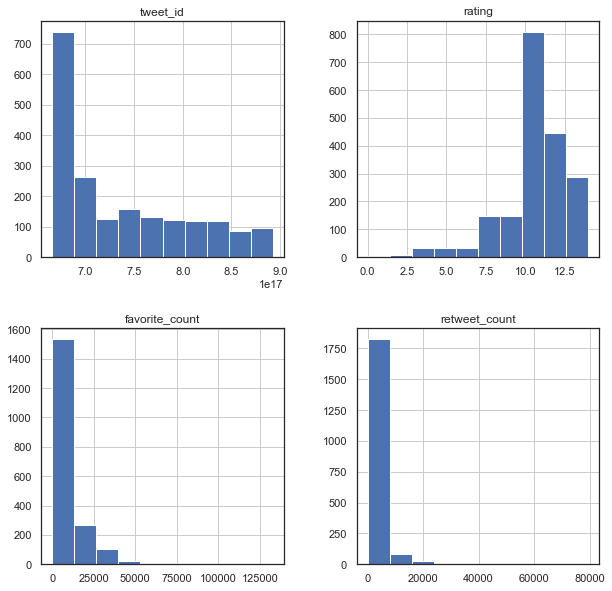

In [89]:
# Using Histogram
master_df_clean.hist(figsize=(10,10));

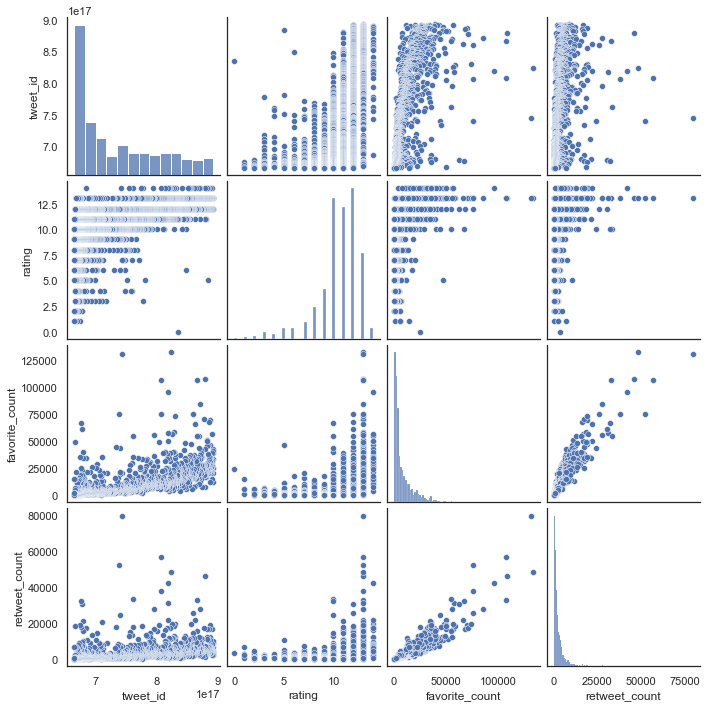

In [90]:
# Using scatter plot of master_df_clean using seaborn
sns_scatterplt = sns.pairplot(master_df_clean)

### 3.2 Visualizing the favorites and retweets

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


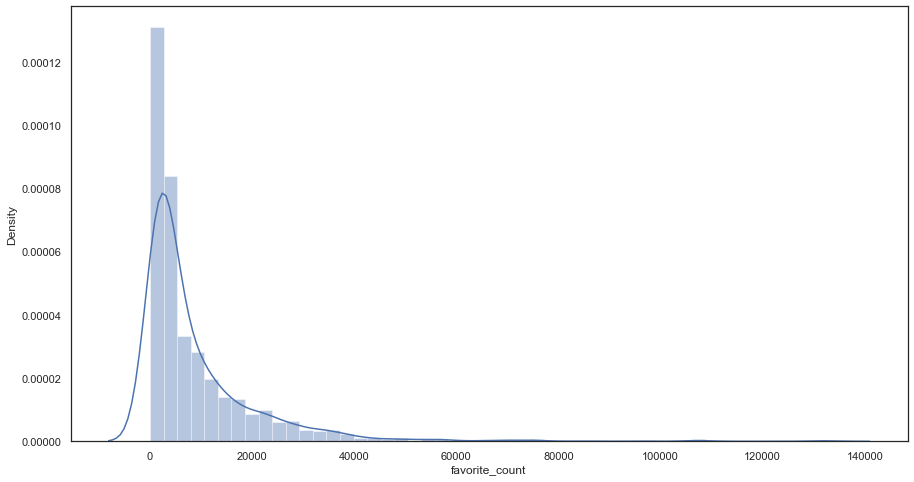

In [91]:
# Visualization for favorite_count distribution:
plt.figure(figsize=(15,8))
sns.distplot(master_df_clean.favorite_count);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


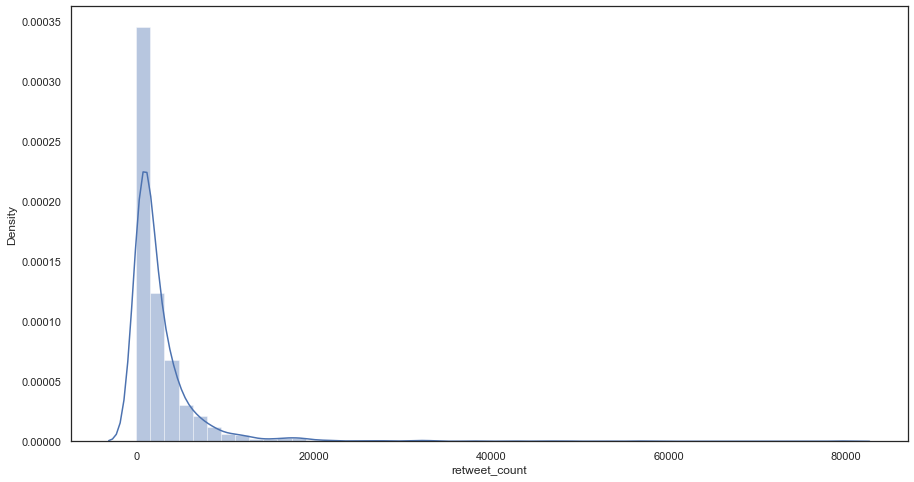

In [92]:
# Visualization for retweet_count distribution:
plt.figure(figsize=(15,8))
sns.distplot(master_df_clean.retweet_count);

#### Favorites Vs. Retweets

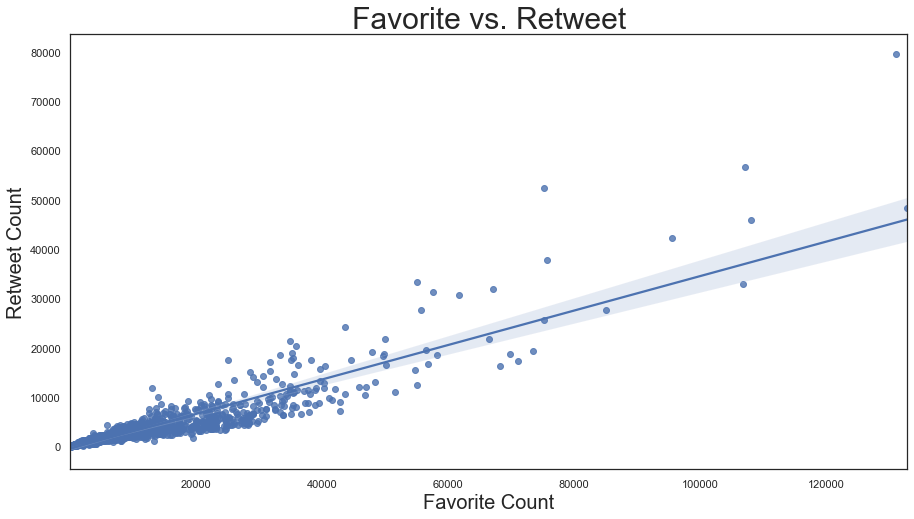

In [93]:
# Seaborn regplot
plt.figure(figsize=(15,8))
plt.title("Favorite vs. Retweet", size=30)
sns.regplot(x='favorite_count', y='retweet_count', data=master_df_clean)
plt.ylabel("Retweet Count", size=20)
plt.xlabel("Favorite Count", size=20);

### 3.3 Visualizing the Dog Ratings

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


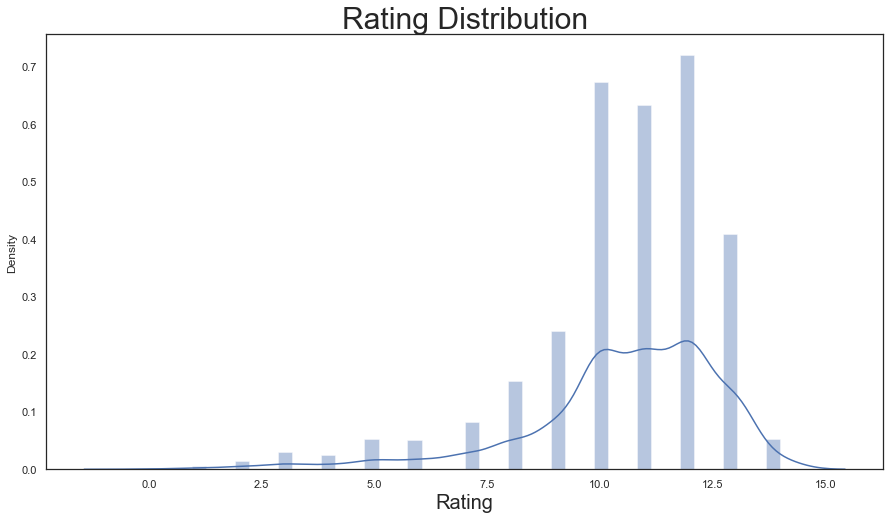

In [94]:
# Visualization for dog rating distribution:
plt.figure(figsize=(15,8))
plt.title("Rating Distribution", size=30)
sns.distplot(master_df_clean.rating)
plt.xlabel("Rating", size=20);

#### Dog Ratings vs. Dog Stages

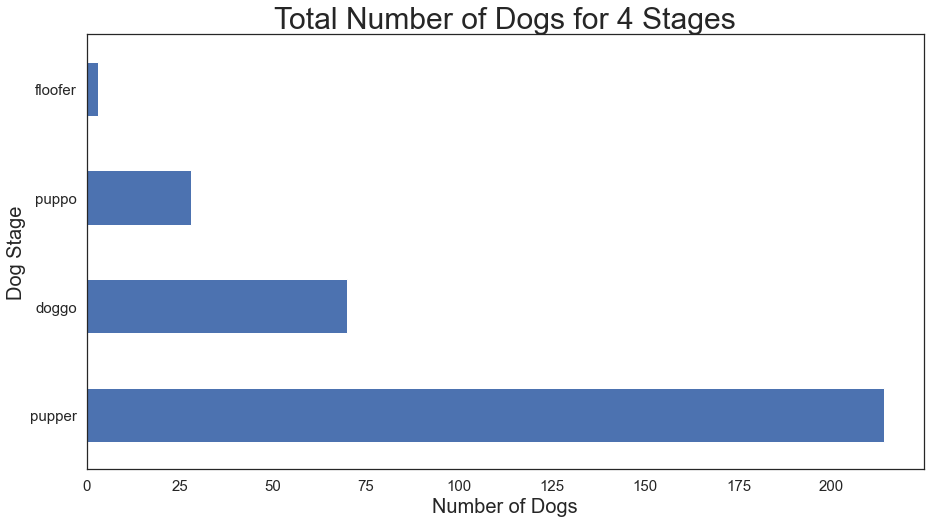

In [95]:
# Plot 4 dog stages
plt.figure(figsize=(15,8))
plt.title("Total Number of Dogs for 4 Stages", size=30)
plt.ylabel("Dog Stage", size=20)
plt.xlabel("Number of Dogs", size=20)
master_df_clean.dog_stage.value_counts().plot(kind='barh', fontsize=15);

In [96]:
# Average rating for all the four dog stages
master_df_clean.groupby(['dog_stage']).mean().rating

dog_stage
doggo      11.642857
floofer    12.666667
pupper     10.560748
puppo      12.142857
Name: rating, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


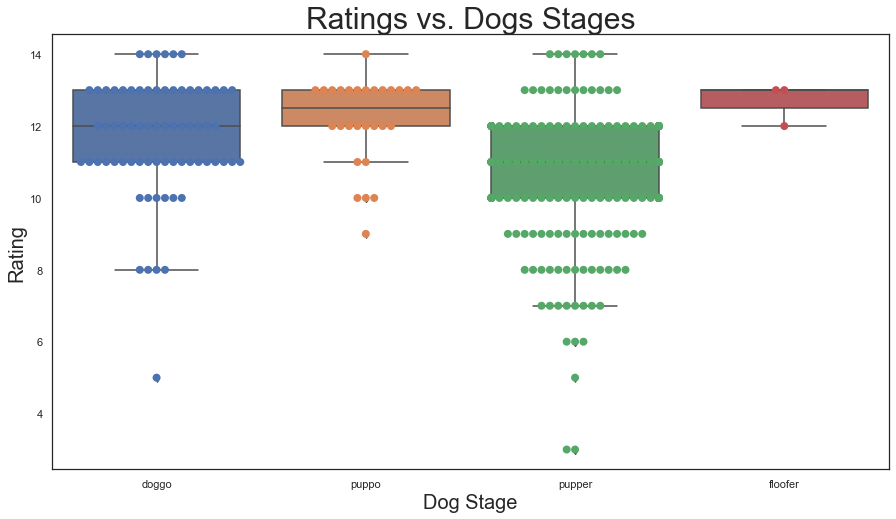

In [97]:
# Set the size of A4 paper
plt.figure(figsize=(15,8))

# Seaborn Swarmplot & Boxplot
X = master_df_clean[master_df_clean.dog_stage.notnull()]
sns.swarmplot(x="dog_stage", y="rating", data=X, size=8)
sns.boxplot(x="dog_stage", y="rating", data=X)

# Change label names and fontsizes
plt.title("Ratings vs. Dogs Stages", size=30)
plt.xlabel('Dog Stage', fontsize=20)
plt.ylabel('Rating', fontsize=20);

#### Dog Ratings vs. Dog Breeds

In [98]:
# For Dog Breed visualization, create new df with only non-null value for 
# dog_breed column
df_dog_breed = master_df_clean[master_df_clean.dog_breed.notnull()]

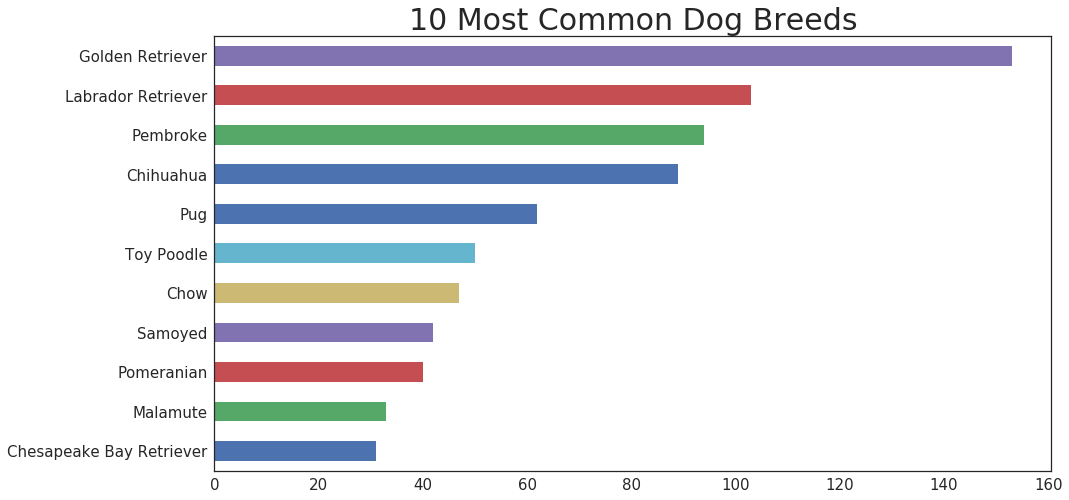

In [171]:
# Plot the 10 most common dog breeds in bar chart
plt.figure(figsize=(15,8))
plt.title("10 Most Common Dog Breeds", size=30)
df_dog_breed['dog_breed'].value_counts()[10::-1].plot(kind='barh',fontsize=15);

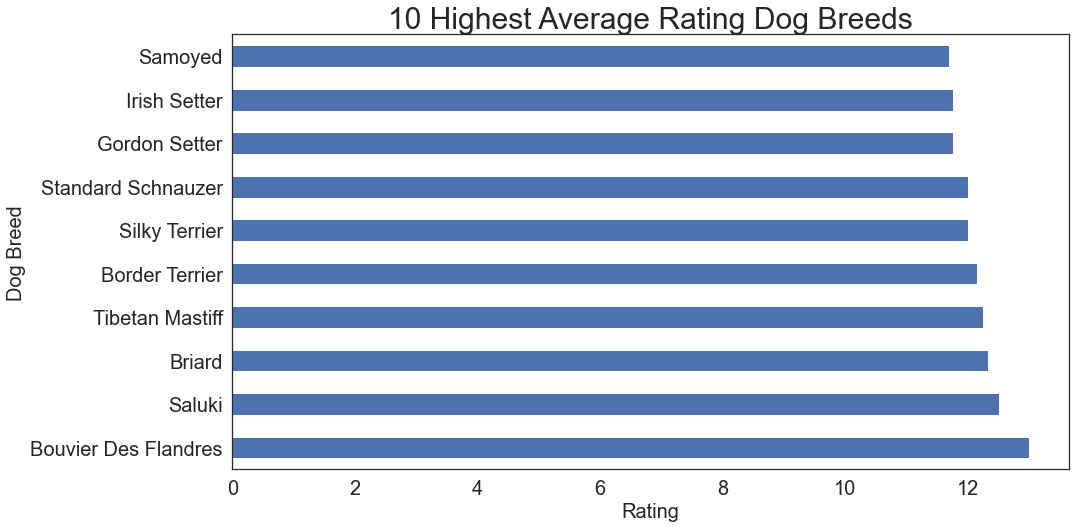

In [99]:
# Extracting the top 10 average rating breeds
top_10_rating = master_df_clean[master_df_clean.dog_breed.notnull()]
top_10_rating = top_10_rating.groupby('dog_breed')['rating'].mean().sort_values(ascending=False).nlargest(10)
plt.figure(figsize=(15,8))
plt.title("10 Highest Average Rating Dog Breeds", size=30)
top_10_rating.plot(kind='barh',fontsize=20)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Dog Breed', fontsize=20);

#### Dog Ratings vs. Sources

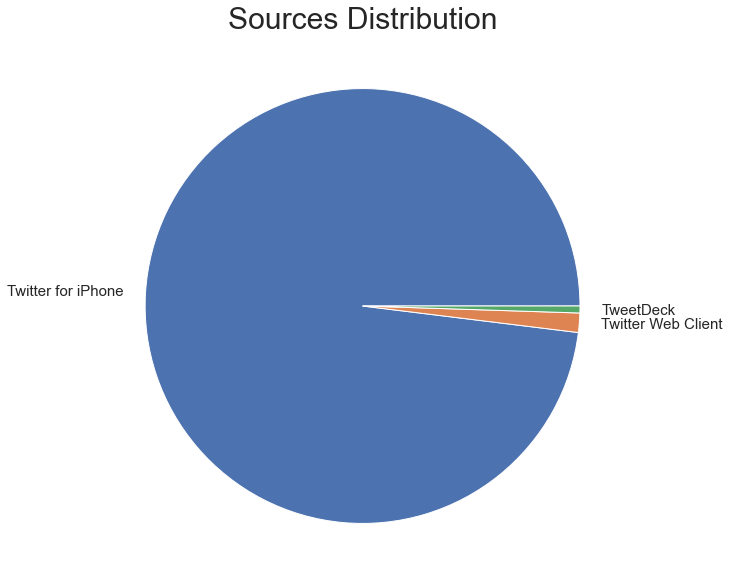

In [100]:
# Plot total counts for 3 sources in pie chart
plt.title("Sources Distribution", size=30)
master_df_clean['source'].value_counts().plot(kind='pie',figsize=(10,10),fontsize=15)
plt.ylabel('');

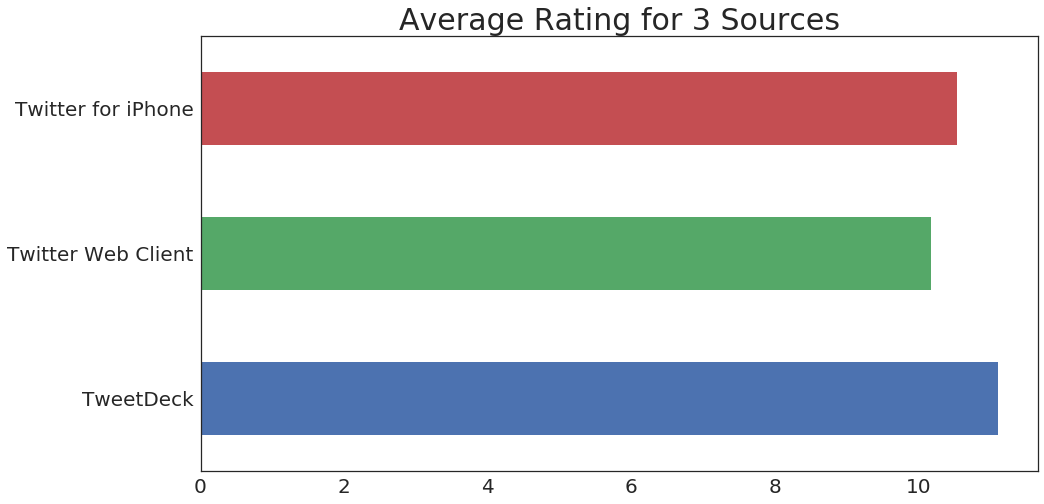

In [180]:
# Plot average rating for 3 sources in bar chart
plt.figure(figsize=(15,8))
plt.title("Average Rating for 3 Sources", size=30)
master_df_clean.groupby(['source']).rating.mean().plot(kind='barh',fontsize=20)
plt.ylabel('', fontsize=20);